## Import Packages

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set figure size for plots
rcParams['figure.figsize'] = 12, 6

## Data Preprocessing and Exploratory Analysis

In [2]:
data_file_path = '../data/time_series_demo_data.csv'
preprocessed_data_dir_path = '../data/preprocessed'
ts_column = 'sales'
ts_alt_column = 'sales2'

In [3]:
def load_and_inspect_data(filepath):
    data = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
    data.sort_index(inplace=True)
    
    print("Dataset Shape:", data.shape)
    
    print("\nData Types:")
    print(data.dtypes)
    
    print("\nFirst 5 rows:")
    print(data.head())
    
    print("\nMissing Values:")
    print(data.isnull().sum())
    
    print("\nBasic Statistics:")
    print(data.describe())
    
    return data

data = load_and_inspect_data(data_file_path)

Dataset Shape: (1827, 10)

Data Types:
sales               float64
temperature         float64
marketing_spend     float64
competitor_price    float64
promotion           float64
month                 int64
day_of_week           int64
day_of_year           int64
is_weekend            int64
sales2              float64
dtype: object

First 5 rows:
                sales  temperature  marketing_spend  competitor_price  \
date                                                                    
2018-01-01  61.535816    21.351839        46.002295         79.767517   
2018-01-02  67.248719    15.681485        51.571458         76.470120   
2018-01-03  68.459373    17.053834        49.977619         77.612312   
2018-01-04  61.674647    23.339900        39.325661         78.361221   
2018-01-05  63.950021    21.824907        37.409351         76.340517   

            promotion  month  day_of_week  day_of_year  is_weekend     sales2  
date                                                        

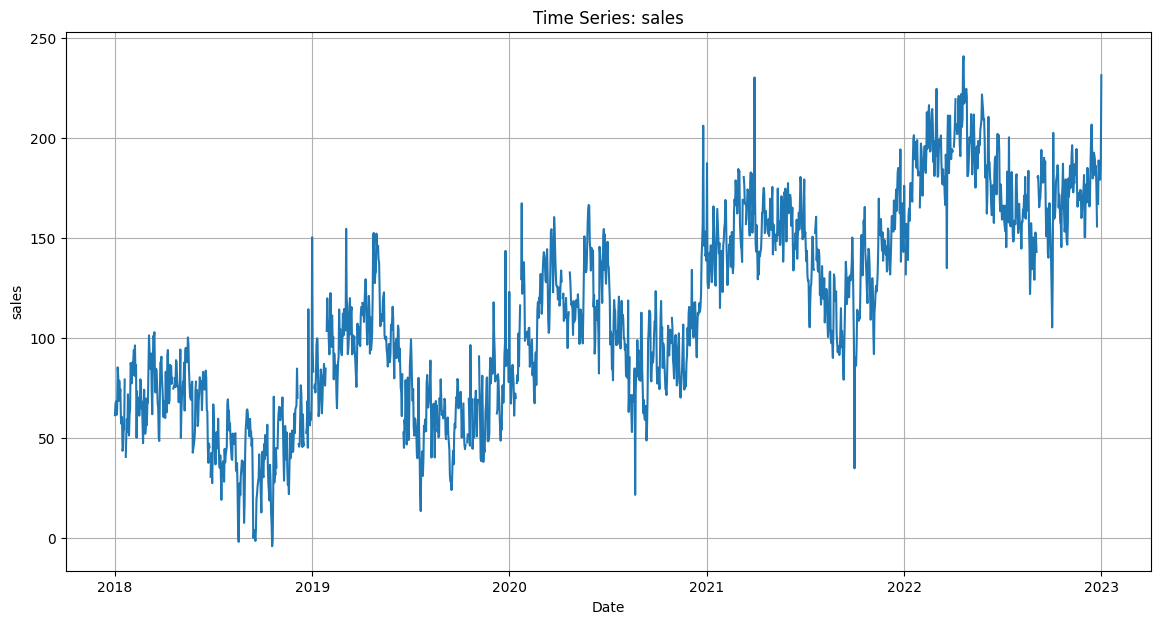

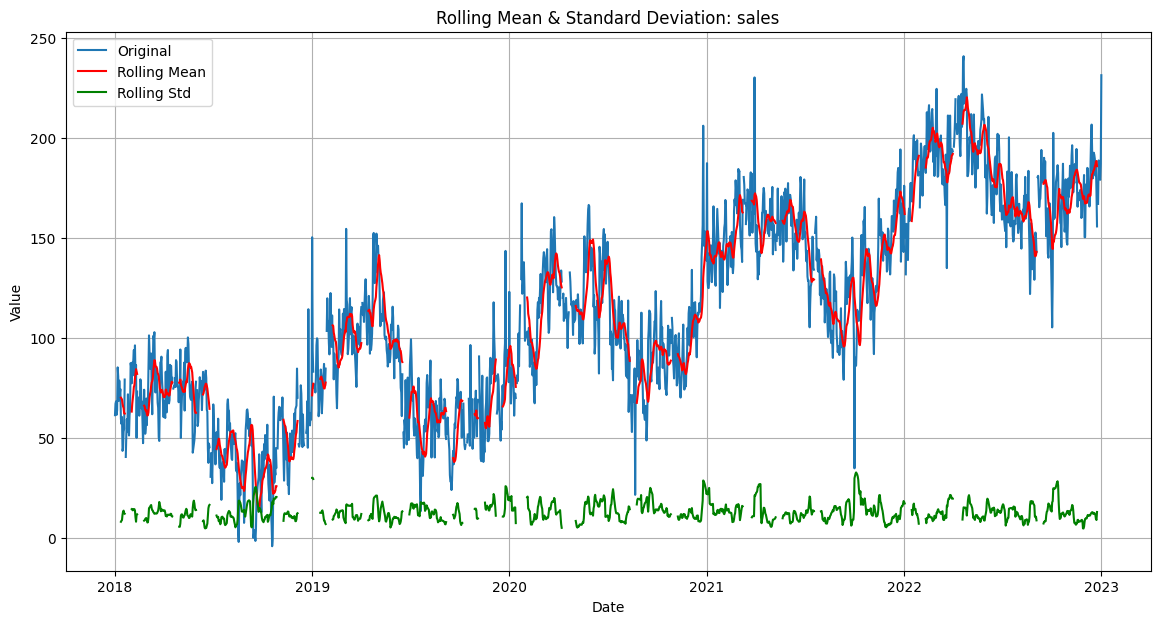

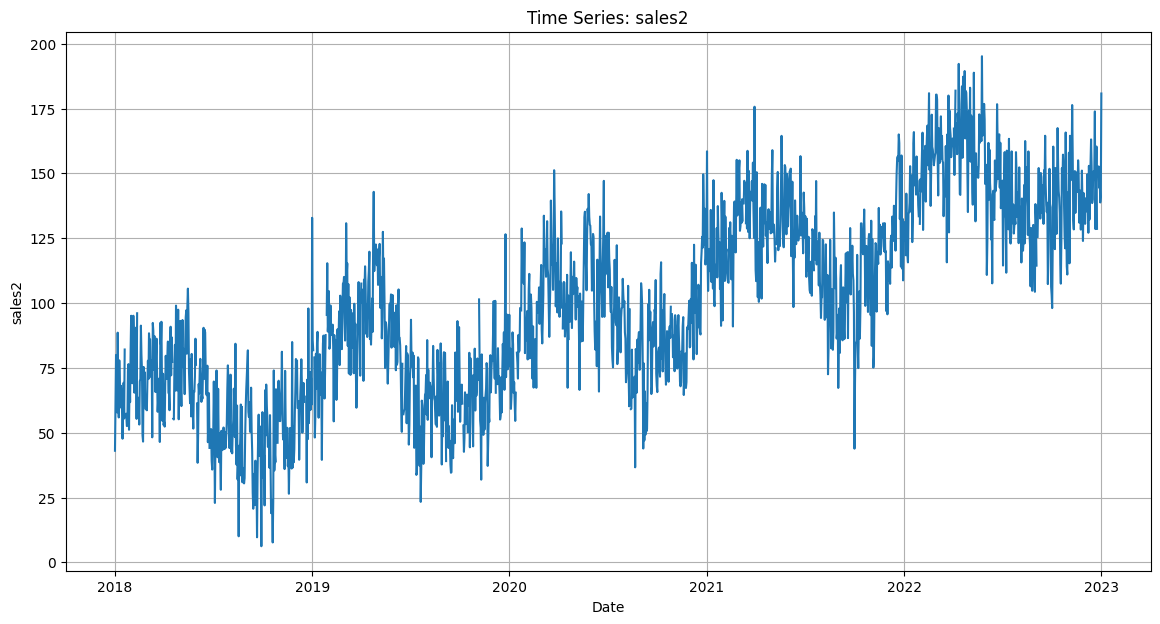

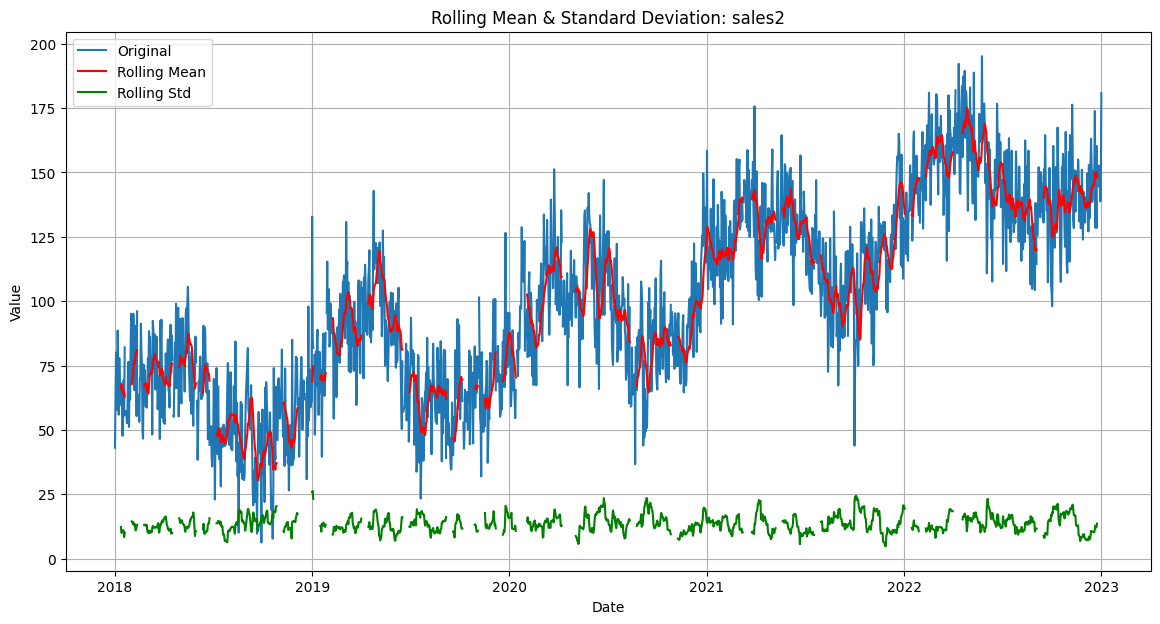

In [4]:
def visualize_time_series(data, column_name):
    plt.figure(figsize=(14, 7))

    plt.plot(data[column_name])
    plt.title(f'Time Series: {column_name}')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.grid(True)
    plt.show()

    # plot rolling mean and standard deviation
    rolling_mean = data[column_name].rolling(window=12).mean()
    rolling_std = data[column_name].rolling(window=12).std()
    plt.figure(figsize=(14, 7))
    plt.plot(data[column_name], label='Original')
    plt.plot(rolling_mean, label='Rolling Mean', color='red')
    plt.plot(rolling_std, label='Rolling Std', color='green')
    plt.title(f'Rolling Mean & Standard Deviation: {column_name}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
visualize_time_series(data, ts_column)
visualize_time_series(data, ts_alt_column)

### Handle missing values and outliers within the Time Series

- **Forward fill**: refers to a method of imputation where values are replaced with the previous valid value in the dataset. This is also called as LOCF (Last Observation Carried Forward) <br><br>
- **Backward fill**: operates by replacing with the next valid value in the dataset (non missing value found in the dataset). <br><br>
- **Linear interpolation**: estimates missed values by assuming a liner relationship between data points: ```y = y1 + ((x - x1) / (x2 - x1)) * (y2 - y1)>``` <br><br>
- **Time-based interpolation**: estimates missed values by considering the temporal order of the data points. It leverages the relationship between data points at different time intervals to fill in the gaps, offering more accurate approach than simply using the mean or median

In [10]:
def handle_missing_values(data):
    missing_values = data.isnull().sum()
    print(f"Missing values before handling: {missing_values}")
    
    # Forward fill
    # data_ffill = data.fillna(method='ffill')
    
    # Backward fill
    # data_bfill = data.fillna(method='bfill')
    
    # Linear interpolation
    #  data_interp = data.interpolate(method='linear')
    
    # Time-based interpolation
    data_time_interp = data.interpolate(method='time')
    missing_values = data_time_interp.isnull().sum()
    print(f"Missing values after handling: {missing_values}")
    return data_time_interp

data_missing_values_handled = handle_missing_values(data)

Missing values before handling: sales               36
temperature          0
marketing_spend      0
competitor_price     0
promotion            0
month                0
day_of_week          0
day_of_year          0
is_weekend           0
sales2              36
dtype: int64
Missing values after handling: sales               0
temperature         0
marketing_spend     0
competitor_price    0
promotion           0
month               0
day_of_week         0
day_of_year         0
is_weekend          0
sales2              0
dtype: int64


- **Z-score Method**: The Z-score method detects outliers by measuring how many standard deviations a data point is away from the mean of the dataset. Data points with z-scores beyond a certain threshold (typically +3 to -3) are considered outliers <br><br>

In [11]:
def handle_outliers(data, column_name, threshold=2):
    data_clean = data.copy()
    
    z_scores = stats.zscore(data_clean[column_name])
    outliers = np.where(np.abs(z_scores) > threshold)
    print(f"Outliers dectected before handling: {len(outliers[0])}")
    if len(outliers[0]) > 0:
        outlier_dates = data_clean.index[outliers]
    
        rolling_median = data_clean[column_name].rolling(window=5, center=True).median()
        data_clean.loc[outlier_dates, column_name] = rolling_median.loc[outlier_dates]
    z_scores = stats.zscore(data_clean[column_name])
    outliers = np.where(np.abs(z_scores) > threshold)
    print(f"Outliers dectected after handling: {len(outliers[0])}")
    return data_clean

data_cleaned = handle_outliers(data_missing_values_handled, ts_column)
data_alt_cleaned = handle_outliers(data_missing_values_handled, ts_alt_column)

Outliers dectected before handling: 37
Outliers dectected after handling: 0
Outliers dectected before handling: 47
Outliers dectected after handling: 0


In [12]:
ts = data_cleaned.loc[:, ts_column]
ts_alt = data_alt_cleaned.loc[:, ts_alt_column]

### Stationary analysis of the Time Series
- ARIMA Hypothesis: provided time series is stationary where the time series has constant mean, variance, and autocovariance over time
- Dickey Fuller Test: evaluates whether the time series has a unit root, which implies the series is not stationary

In [13]:
def check_stationarity(timeseries):
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key, value in dftest[4].items():
            dfoutput['Critical Value (%s)' % key] = value
            print(dfoutput)
        
        if dftest[1] <= 0.05:
            print("\nThe series is stationary (reject H0)")
        else:
            print("\nThe series is non-stationary (fail to reject H0)")

In [14]:
check_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                         NaN
p-value                                NaN
#Lags Used                        0.000000
Number of Observations Used    1826.000000
Critical Value (1%)              -3.433936
dtype: float64
Test Statistic                         NaN
p-value                                NaN
#Lags Used                        0.000000
Number of Observations Used    1826.000000
Critical Value (1%)              -3.433936
Critical Value (5%)              -2.863124
dtype: float64
Test Statistic                         NaN
p-value                                NaN
#Lags Used                        0.000000
Number of Observations Used    1826.000000
Critical Value (1%)              -3.433936
Critical Value (5%)              -2.863124
Critical Value (10%)             -2.567613
dtype: float64

The series is non-stationary (fail to reject H0)


In [15]:
check_stationarity(ts_alt)

Results of Dickey-Fuller Test:
Test Statistic                         NaN
p-value                                NaN
#Lags Used                        0.000000
Number of Observations Used    1826.000000
Critical Value (1%)              -3.433936
dtype: float64
Test Statistic                         NaN
p-value                                NaN
#Lags Used                        0.000000
Number of Observations Used    1826.000000
Critical Value (1%)              -3.433936
Critical Value (5%)              -2.863124
dtype: float64
Test Statistic                         NaN
p-value                                NaN
#Lags Used                        0.000000
Number of Observations Used    1826.000000
Critical Value (1%)              -3.433936
Critical Value (5%)              -2.863124
Critical Value (10%)             -2.567613
dtype: float64

The series is non-stationary (fail to reject H0)


In [16]:
def make_stationary(timeseries, seasonal_diff=None | int):
   # 1. Log transformation (reduces variance, handles exponential growth)
    if (timeseries > 0).all(): 
        ts_log = np.log(timeseries)
        plt.figure(figsize=(14, 5))
        plt.plot(ts_log, label='Log Transformed')
        plt.title('Log Transformation')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        ts_log = timeseries
        print("Skipping log transformation as data contains zero or negative values")

    # 2. Differencing (removes trend)
    ts_diff = ts_log.diff().dropna()
    plt.figure(figsize=(14, 5))
    plt.plot(ts_diff, label='Differenced')
    plt.title('Differenced Series (First Order)')
    plt.legend()
    plt.grid(True)
    plt.show()

    if seasonal_diff:
        # 3. Seasonal differencing (if applicable)
        # Example with 12 for monthly seasonality
        if len(ts_log) > 24: # Ensure enough data points
            ts_seasonal_diff = ts_log.diff(seasonal_diff).dropna()
            plt.figure(figsize=(14, 5))
            plt.plot(ts_seasonal_diff, label='Seasonally Differenced')
            plt.title(f'Seasonally Differenced Series (Difference: {seasonal_diff})')
            plt.legend()
            plt.grid(True)
            plt.show()
    # Check stationarity of transformed series
    print("\nStationarity check after first differencing:")
    check_stationarity(ts_diff)
    return ts_diff, ts_seasonal_diff

Skipping log transformation as data contains zero or negative values


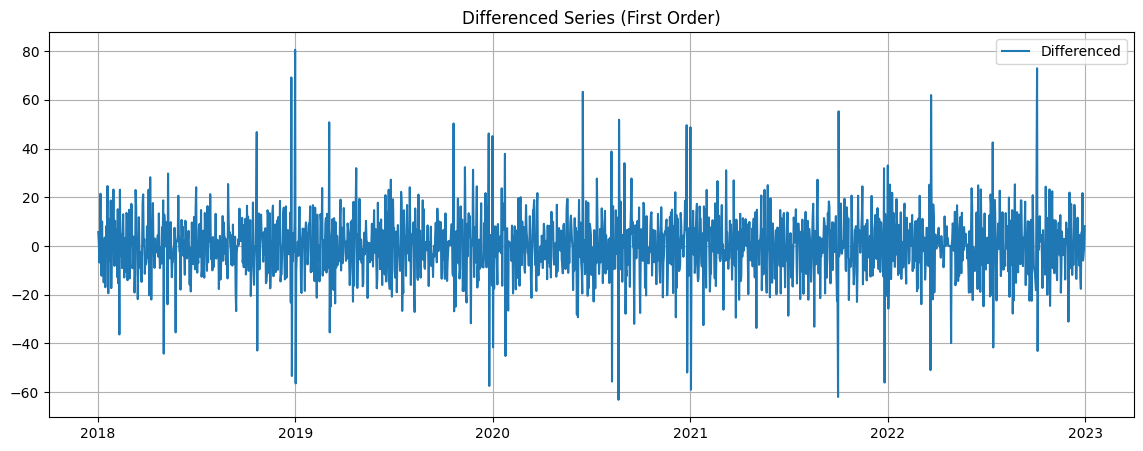

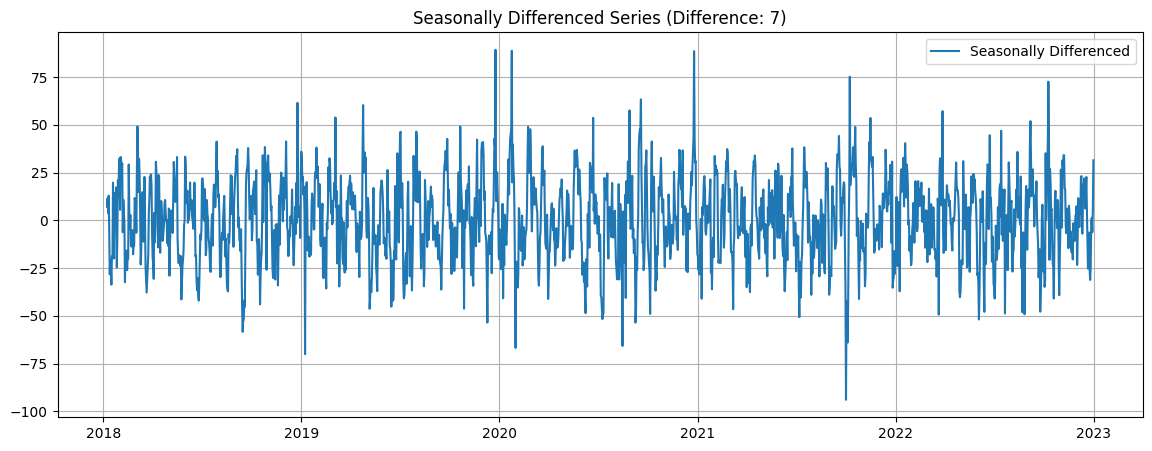


Stationarity check after first differencing:
Results of Dickey-Fuller Test:
Test Statistic                -1.439961e+01
p-value                        8.552490e-27
#Lags Used                     2.500000e+01
Number of Observations Used    1.799000e+03
Critical Value (1%)           -3.433990e+00
dtype: float64
Test Statistic                -1.439961e+01
p-value                        8.552490e-27
#Lags Used                     2.500000e+01
Number of Observations Used    1.799000e+03
Critical Value (1%)           -3.433990e+00
Critical Value (5%)           -2.863148e+00
dtype: float64
Test Statistic                -1.439961e+01
p-value                        8.552490e-27
#Lags Used                     2.500000e+01
Number of Observations Used    1.799000e+03
Critical Value (1%)           -3.433990e+00
Critical Value (5%)           -2.863148e+00
Critical Value (10%)          -2.567626e+00
dtype: float64

The series is stationary (reject H0)
Skipping log transformation as data contains zer

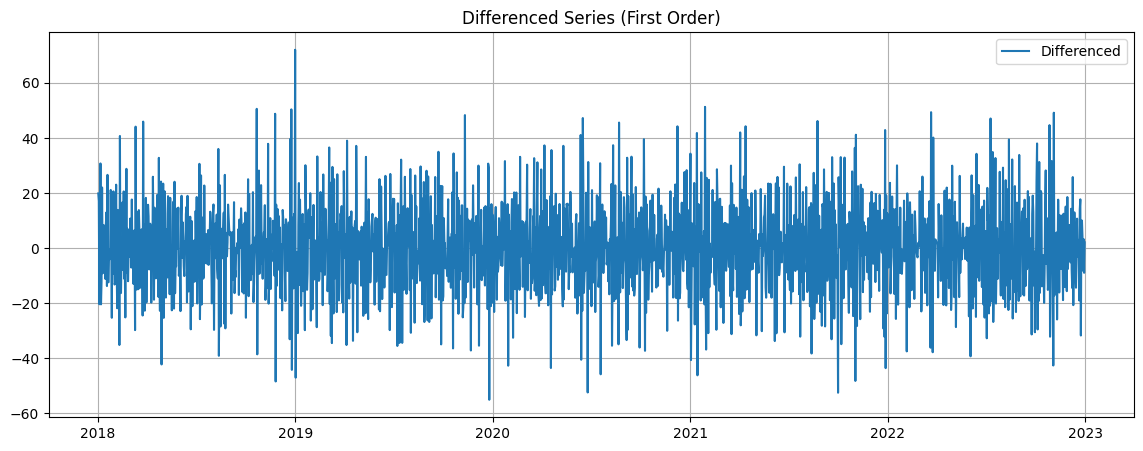

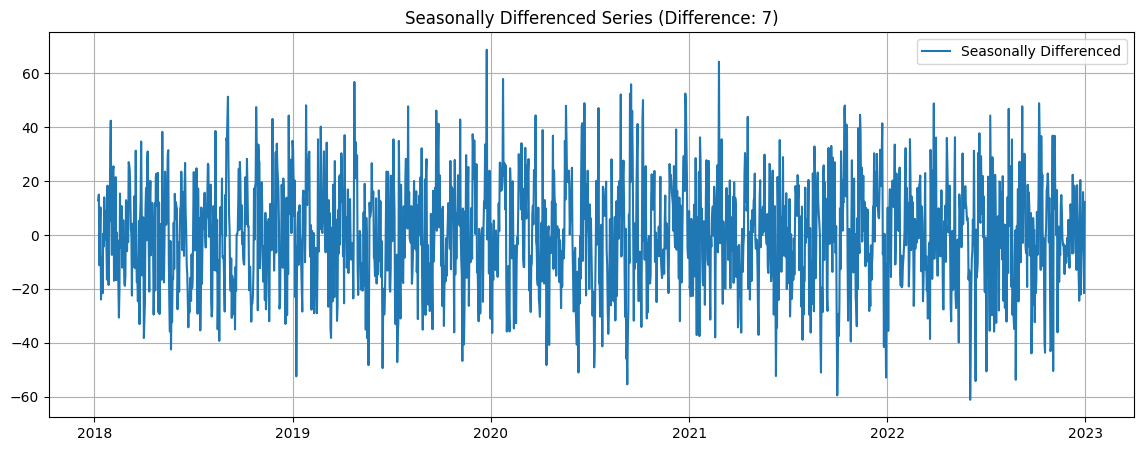


Stationarity check after first differencing:
Results of Dickey-Fuller Test:
Test Statistic                -1.445011e+01
p-value                        7.121510e-27
#Lags Used                     2.500000e+01
Number of Observations Used    1.799000e+03
Critical Value (1%)           -3.433990e+00
dtype: float64
Test Statistic                -1.445011e+01
p-value                        7.121510e-27
#Lags Used                     2.500000e+01
Number of Observations Used    1.799000e+03
Critical Value (1%)           -3.433990e+00
Critical Value (5%)           -2.863148e+00
dtype: float64
Test Statistic                -1.445011e+01
p-value                        7.121510e-27
#Lags Used                     2.500000e+01
Number of Observations Used    1.799000e+03
Critical Value (1%)           -3.433990e+00
Critical Value (5%)           -2.863148e+00
Critical Value (10%)          -2.567626e+00
dtype: float64

The series is stationary (reject H0)


In [ ]:
result = make_stationary(ts, seasonal_diff=12)
ts_diff, ts_seasonal_diff = result[0], result[1]
result = make_stationary(ts_alt, seasonal_diff=12)
ts_alt_diff, ts_alt_seasonal_diff = result[0], result[1]

In [60]:
np.save(os.path.join(preprocessed_data_dir_path, 'sales_diff.npy'), ts_diff)
np.save(os.path.join(preprocessed_data_dir_path, 'sales2_diff.npy'), ts_alt_diff)
np.save(os.path.join(preprocessed_data_dir_path, 'sales_seasonal_diff.npy'), ts_seasonal_diff)
np.save(os.path.join(preprocessed_data_dir_path, 'sales2_seasonal_diff.npy'), ts_alt_seasonal_diff)